# Fuego contra Fuego

> Fuego contra fuego es amar.

Ricky Martin

Instalamos, cargamos y seteamos el entorno

In [ ]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
%pip install optuna==3.6.1


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from joblib import Parallel, delayed

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle


In [3]:
base_path = '/content/drive/MyDrive/DMEyF/2024/'
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202102
mes_test = 202104

# agregue sus semillas
semillas = [17,19,23,29,31]

data = pd.read_csv(dataset_path + dataset_file)

Seguimos trabajando con Febrero como entrenamiento y Abril como test.

In [4]:
X = data[data['foto_mes'] == mes_train]
y = X['clase_ternaria']
X = X.drop(columns=['clase_ternaria'])

In [5]:
X_futuro = data[data['foto_mes'] == mes_test]
y_futuro = X_futuro['clase_ternaria']
X_futuro = X_futuro.drop(columns=['clase_ternaria'])

Y variaremos la forma de la función de ganancia, para poder ser utilizada de una forma más genérica.

In [6]:
def ganancia_prob(y_hat, y, prop=1, class_index=1, threshold=0.025):
  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == "BAJA+2" else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop



Ajustamos los modelos de la clase pasada.

In [7]:
param_ale = {'max_depth': 5,
             'min_samples_split': 80}

param_opt = {'criterion': 'entropy',
             'max_depth': 20,
             'min_samples_split': 145,
             'min_samples_leaf': 14,
             'max_leaf_nodes': 13}

model_base = DecisionTreeClassifier(random_state=semillas[0])
model_ale = DecisionTreeClassifier(random_state=semillas[0], **param_ale)
model_opt = DecisionTreeClassifier(random_state=semillas[0], **param_opt)

model_base.fit(X, y)
model_ale.fit(X, y)
model_opt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=20, max_leaf_nodes=13,
                       min_samples_leaf=14, min_samples_split=145,
                       random_state=17)

In [8]:
y_pred_base = model_base.predict_proba(X_futuro)
y_pred_ale = model_ale.predict_proba(X_futuro)
y_pred_opt = model_opt.predict_proba(X_futuro)

Recordemos la ganancia de cada uno en Abril

In [9]:
print(f"Ganancia de modelo Base: {ganancia_prob(y_pred_base, y_futuro)}")
print(f"Ganancia de modelo Ale: {ganancia_prob(y_pred_ale, y_futuro)}")
print(f"Ganancia de modelo Opt: {ganancia_prob(y_pred_opt, y_futuro)}")

Ganancia de modelo Base: 111265000.0
Ganancia de modelo Ale: 112910000.0
Ganancia de modelo Opt: 114373000.0


Antes de continuar con nuestro camino de estrés y sumeración, analizaremos que tan bien hubieramos elegido un modelo de acuerdo a utilizar un leaderboard público. Primero comparamos el **base** y el **ale**

In [10]:
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])
modelos = {"base": y_pred_base, "ale": y_pred_ale}
rows = []
for private_index, public_index in sss_futuro.split(X_futuro, y_futuro):
  row = {}
  for name, y_pred in modelos.items():
    row[name + "_private"] = ganancia_prob(y_pred[private_index], y_futuro.iloc[private_index], 0.7)
    row[name + "_public"] = ganancia_prob(y_pred[public_index], y_futuro.iloc[public_index], 0.3)
  rows.append(row)
df_lb = pd.DataFrame(rows)

Una forma de ver si una distribución es distinta a otra es usar el test de wilcoxon. Este test se usa para determinar si hay una diferencia significativa en las medianas de dos muestras dependientes.

Lo vamos a aplicar sobre nuestro simulado leaderboard público con la esperanza que nos ayude a eligir cual de los dos es mejor, para esa muestra.

(Recuerde, no se esta aplicando al Leaderboard público real. Técnicamente estamos aplicandolo a un out of time sample)

In [11]:
from scipy.stats import wilcoxon

diff_public = df_lb['base_public'] - df_lb['ale_public']
_, p_value = wilcoxon(diff_public)

print(f"p-value: {p_value}")


p-value: 0.020120643634562896


Espero que sus recuerdos traumaticos de estadísticas le ayuden a leer que la prueba plantea que ambas distribuciones son lo diferentes, y **ale** es mayor.

Veremos con el privado que tan bien nos hubiera ido.

In [12]:
df = pd.DataFrame()

df['best_public'] = df_lb.filter(regex='_public').idxmax(axis=1)
df['best_private'] = df_lb.filter(regex='_private').idxmax(axis=1)

In [13]:
pd.crosstab(df['best_public'], df['best_private'])

best_private,ale_private,base_private
best_public,,
ale_public,22,11
base_public,17,0


Sus opiniones. Volvemos al panic de la clase pasada, no? Vamos a agregar el modelo optimizado a la comparación

In [14]:
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])
modelos = {"opt":y_pred_opt}
rows = []
for private_index, public_index in sss_futuro.split(X_futuro, y_futuro):
  row = {}
  for name, y_pred in modelos.items():
    row[name + "_private"] = ganancia_prob(y_pred[private_index], y_futuro.iloc[private_index], 0.7)
    row[name + "_public"] = ganancia_prob(y_pred[public_index], y_futuro.iloc[public_index], 0.3)
  rows.append(row)
df_temp = pd.DataFrame(rows)
df_lb = pd.concat([df_lb, df_temp], axis=1)

In [15]:
df['best_public'] = df_lb.filter(regex='_public').idxmax(axis=1)
df['best_private'] = df_lb.filter(regex='_private').idxmax(axis=1)

pd.crosstab(df['best_public'], df['best_private'])


best_private,ale_private,base_private,opt_private
best_public,,,
ale_public,0,0,11
base_public,1,0,8
opt_public,11,6,13


Sus reflexiones.

---
.

.

.

.

.

.

---

Creo que necesitamos algo superador. Para eso nos abrazaremos al problema, todo el daño que produce el azar, será la luz que resuelva nuestro problema.

Primero hablamos de ensemables, qué son?

* Un ensemble de modelos es una técnica donde se combinan múltiples modelos individuales para mejorar la precisión y robustez de las predicciones. La idea es que al combinar varios modelos, se pueden aprovechar las fortalezas de cada uno y reducir la posibilidad de errores que podría cometer un único modelo.

* **Tipos de ensemble**:
 * **Bagging (Bootstrap Aggregating)**: Consiste en entrenar varios modelos base en diferentes subconjuntos del conjunto de datos de entrenamiento obtenidos mediante técnicas de remuestreo como el bootstrap y luego promediar sus predicciones. Ejemplo: **Random Forest**
 * **Boosting**: En esta técnica, los modelos se entrenan de manera secuencial. Cada modelo intenta corregir los errores cometidos por el modelo anterior. Ejemplo: AdaBoost y **Gradient Boosting**.
 * **Stacking**: En el stacking, se entrenan varios modelos y se combinan usando un "modelo meta". Las predicciones de los modelos base sirven como features para entrenar este modelo meta, que produce la predicción final.

* **Ventajas de usar ensemble de modelos**:
 * **Mejor rendimiento**: Al combinar modelos, generalmente se mejora la precisión en comparación con un solo modelo.
 * **Robustez**: Al integrar diferentes modelos, se mitiga el riesgo de que los errores de un modelo individual afecten gravemente la predicción final.




Pongamos foco en el **Random Forest**

Es un algoritmo de aprendizaje automático que funciona creando un conjunto de árboles de decisión. Para la creación de **árboles distintos** utiliza una técnica llamada bagging para crear múltiples subconjuntos del conjunto de datos de entrenamiento. Cada subconjunto se genera seleccionando al azar muestras del conjunto de datos original con reemplazo. No usa la totalidad de los datos de entrenamiento para cada conjunto. Los datos que quedan fueran son conocidos como **Out of Bag (oob)**

Para cada subconjunto, se construye un árbol de decisión. Sin embargo en cada nodo del árbol, **Random Forest** selecciona de forma aleatoria un grupo de variables y ajusta el árbol con esas variables. Este proceso ayuda a crear árboles que son menos correlacionados entre sí.

Cada árbol en el bosque se entrena de manera independiente usando su respectivo subconjunto de datos. Lueago, para una nueva observación, cada árbol realiza una predicción. El Random Forest luego combina las predicciones de todos los árboles para hacer una predicción final, devolviendo el promedio de las probabilidades de cada árbol individual.



Como desde la clase pasada solo personas más inteligentes, no vamos a empezar a probar **Random Forest** simples. Vamos a parametrizarlo desde el vamos.

Primero vamos a entender algunas limitaciones de la implementación:

El **Random Forest** no soporta nulos! Shame on you sklearn!.

Vamos a tener que imputar los datos. Discutamos entre todos forma de imputar los datos, mientras para salir del paso usamos la peor de todas.

In [16]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
Xi = imp_mean.fit_transform(X)
Xif = imp_mean.fit_transform(X_futuro)

Los parámetros que se pueden ajustar en el **rf** son

1. **n_estimators**: Número de árboles en el bosque.
2. **max_depth**: Profundidad máxima de los árboles.
3. **min_samples_split**: Número mínimo de muestras requeridas para dividir un nodo interno.
4. **min_samples_leaf**: Número mínimo de muestras requeridas para estar en un nodo hoja.
5. **max_features**: Número de features a usar en cada árbol. **sqrt** es una elección histórica.
6. **max_leaf_nodes**: Número máximo de nodos hoja en cada árbol.
7. **oob_score**: Indica si se usa la muestra fuera de bolsa (out-of-bag) para estimar la calidad del modelo. Para evitar hacer un **montecarlo-cross-validation** que se toma su tiempo, usaremos esta opción para buscar el mejor modelo. No es la mejor opción. Pero no es tan mala.
8. **n_jobs**: Siempre -1, para que use todos los cores presentes en 9. **max_samples**: Fracción de los samples.

Finalmente nuestra función de optimización queda la siguiente forma:

In [17]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 2000)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 200)
    max_features = trial.suggest_float('max_features', 0.05, 0.7)

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_samples=0.7,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True
    )

    model.fit(Xi, y)

    return ganancia_prob(model.oob_decision_function_, y)

storage_name = "sqlite:///" + db_path + "optimization_tree.db"
study_name = "exp_206_random-forest-opt"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)



[I 2024-09-01 20:43:14,464] Using an existing study with name 'exp_206_random-forest-opt' instead of creating a new one.


In [ ]:
# study.optimize(objective, n_trials=100)

[I 2024-08-28 01:24:57,265] Trial 0 finished with value: 85512000.0 and parameters: {'max_depth': 19, 'min_samples_split': 1953, 'min_samples_leaf': 94, 'max_features': 0.12305127359287728}. Best is trial 0 with value: 85512000.0.
[I 2024-08-28 01:25:07,194] Trial 1 finished with value: 85911000.0 and parameters: {'max_depth': 4, 'min_samples_split': 1124, 'min_samples_leaf': 38, 'max_features': 0.530725801717589}. Best is trial 1 with value: 85911000.0.
[I 2024-08-28 01:25:16,612] Trial 2 finished with value: 92239000.0 and parameters: {'max_depth': 21, 'min_samples_split': 898, 'min_samples_leaf': 101, 'max_features': 0.16118177704034425}. Best is trial 2 with value: 92239000.0.
[I 2024-08-28 01:25:33,048] Trial 3 finished with value: 90797000.0 and parameters: {'max_depth': 23, 'min_samples_split': 1667, 'min_samples_leaf': 129, 'max_features': 0.5469475981941461}. Best is trial 2 with value: 92239000.0.
[I 2024-08-28 01:25:50,165] Trial 4 finished with value: 89915000.0 and paramet

Exploramos como fue la búsqueda de parámetros

In [18]:
optuna.visualization.plot_optimization_history(study)

In [19]:
plot_param_importances(study)

In [20]:
plot_slice(study)

In [21]:
plot_contour(study)

In [22]:
plot_contour(study, params=["max_depth", "min_samples_split"])

Ajustamos el mejor modelo

In [23]:
model_rf = RandomForestClassifier(
        n_estimators=100,
        **study.best_params,
        max_samples=0.7,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True
    )

# model_rf.fit(Xi, y)


Guardamos el modelo, para no tener que optimizar cada vez que lo queramos usar.

In [24]:
filename = modelos_path + 'exp_206_random_forest_model_100.sav'
# pickle.dump(model_rf, open(filename, 'wb'))


Y lo cargamos para utilizarlo

In [25]:
model_rf = pickle.load(open(filename, 'rb'))
model_rf

RandomForestClassifier(max_depth=28, max_features=0.29056171212579845,
                       max_samples=0.7, min_samples_leaf=138,
                       min_samples_split=5, n_jobs=-1, random_state=17)

Ahora vamos medir su ganancia sobre el dataset de **abril**

In [26]:
y_pred_rf = model_rf.predict_proba(Xif)
ganancias_rf = ganancia_prob(y_pred_rf, y_futuro)
print(f"Ganancia de modelo RF: {ganancias_rf}")

Ganancia de modelo RF: 135723000.0


What!? Qué paso? que son esos números???

Algo malo que hicimos, es usar poquitos estimadores. Tan solo unos 100. Suficientes como para que la optimización no tarde una eternidad, pero es muy poco. Deberíamos sumar unos cuantos más.

In [27]:
model_rf_1000 = RandomForestClassifier(
        n_estimators=1000,
        **study.best_params,
        max_samples=0.7,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True
    )

# model_rf_1000.fit(Xi, y)

filename_rf_1000 = modelos_path + 'exp_206_random_forest_model_1000.sav'
# pickle.dump(model_rf, open(filename_rf_1000, 'wb'))

model_rf_1000 = pickle.load(open(filename_rf_1000, 'rb'))
model_rf_1000

RandomForestClassifier(max_depth=28, max_features=0.29056171212579845,
                       max_samples=0.7, min_samples_leaf=138,
                       min_samples_split=5, n_estimators=1000, n_jobs=-1,
                       random_state=17)

Veamos si sumar 10 veces más estimadores tuvo algún efecto

In [28]:
y_pred_rf = model_rf_1000.predict_proba(Xif)
ganancias_rf = ganancia_prob(y_pred_rf, y_futuro)
print(f"Ganancia de modelo RF 1000: {ganancias_rf}")

Ganancia de modelo RF 1000: 136402000.0


Mejoró! Cada peso vale.

Sin embargo, es este modelo tan superior o será ese número lindo.

Calculemos su impacto en los leaderboard

In [29]:
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])
modelos = {"rf":y_pred_rf}
rows = []
for private_index, public_index in sss_futuro.split(X_futuro, y_futuro):
  row = {}
  for name, y_pred in modelos.items():
    row[name + "_private"] = ganancia_prob(y_pred[private_index], y_futuro.iloc[private_index], 0.7)
    row[name + "_public"] = ganancia_prob(y_pred[public_index], y_futuro.iloc[public_index], 0.3)
  rows.append(row)
df_temp = pd.DataFrame(rows)
df_lb = pd.concat([df_lb, df_temp], axis=1)

In [30]:
df = pd.DataFrame()
df['best_public'] = df_lb.filter(regex='_public').idxmax(axis=1)
df['best_private'] = df_lb.filter(regex='_private').idxmax(axis=1)

pd.crosstab(df['best_public'], df['best_private'])

best_private,rf_private
best_public,
rf_public,50


Vaya! es lo que buscabamos, un modelo del que estar seguros. Podrémos ver esto en los histogramas?

In [31]:
df_lb_long = df_lb.reset_index()
df_lb_long = df_lb_long.melt(id_vars=['index'], var_name='model_type', value_name='ganancia')
df_lb_long[['modelo', 'tipo']] = df_lb_long['model_type'].str.split('_', expand=True)
df_lb_long = df_lb_long[['ganancia', 'tipo', 'modelo']]

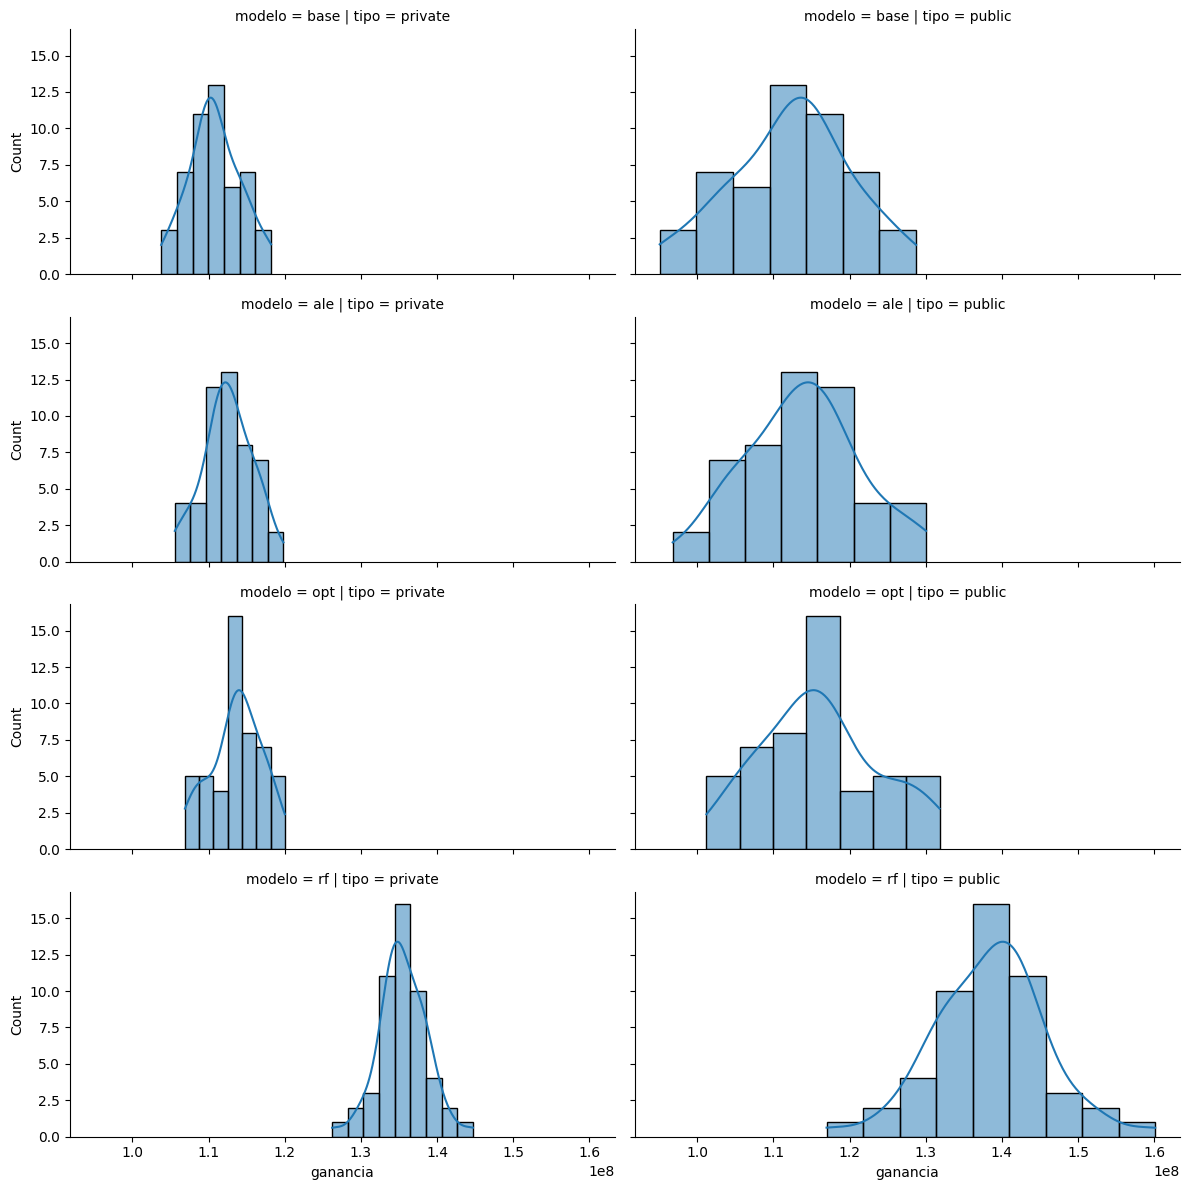

In [33]:
g = sns.FacetGrid(df_lb_long, col="tipo", row="modelo", aspect=2)
g.map(sns.histplot, "ganancia", kde=True)
plt.show()


Por último evaluamos cuales son las variables más importantes del modelo. ¿Habrá influido la imputación?

In [34]:
importances = model_rf.feature_importances_

features = X.columns
feat_importances = pd.DataFrame({'feature': features, 'importance': importances})
feat_importances = feat_importances.sort_values('importance', ascending=False)

feat_importances.head(25)


,feature,importance
107,ctrx_quarter,0.174211
18,mcaja_ahorro,0.087237
2,active_quarter,0.075421
11,mpasivos_margen,0.070022
22,mcuentas_saldo,0.058028
33,mprestamos_personales,0.048968
16,mcuenta_corriente,0.048963
28,mtarjeta_visa_consumo,0.031140
8,mrentabilidad_annual,0.028972
32,cprestamos_personales,0.028144


Felicitaciones! ahora sabe como superar un **árbol de decisión**.

Pregunta:
* **¿Cómo sabe que un random forest es superior a otro?**
* **¿Cómo supera el random forest presentado?**

## Tarea:

* Envíe a modelo de **rf** a Kaggle
* Mejore la parametrización del **rf**
* Juegue un poco:
 * Borre la variable más importante y mida el **rf**.
 * Agregue variables 100% aleatorias. ¿Salen dentro de las variables más importante?
 * No probamos en **rf** en el mismo dataset de entrenamiento. ¿Se puede decir que sobre ajusta?